# Creating the final model

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt

plt.style.use('seaborn')
sns.set(style="white")

In [58]:
df = pd.read_pickle('Residuals_df')

#### Creating interaction terms dataframe

In [59]:
interms = df.copy() # copy the df to not mess up original data

# dropping columns that should not interact
interms = interms.drop(['dteday','season','yr','mnth','weekday','atemp','weathersit','casual',
                        'registered','cnt','weather','resids','predictions'],axis=1)

In [60]:
# using PolynomialFeatures to interact everything in the interms df
poly1 = PolynomialFeatures(3)
poly_data = poly1.fit_transform(interms)
poly_columns = poly1.get_feature_names(list(interms.columns))
poly_features = pd.DataFrame(poly_data, columns=poly_columns, index=interms.index)

 - Cleaning up the interaction terms df

In [61]:
new_cols = list(poly_features.columns)

# getting rid of the columns that were interacted with themselves (i.e.  df['temp^2'])
poly_features = poly_features.drop([name for name in new_cols if '^' in name],axis=1)

# getting rid of all columns that were only 0 values
# this essentially got rid of all columns where a season interacted with another season, which doesn't make sense
poly_features = poly_features.loc[:, (poly_features != 0).any(axis=0)]

#### Final dataframe to use for model

In [62]:
# combining the original dataframe with the interaction terms dataframe
final_df = pd.concat([df, poly_features],axis=1)

# making column names usable by replacing empty space with underscores(_)
final_df.columns = [name.replace(' ','_') for name in final_df.columns]

# getting rid of any duplicate columns that were made in the combining process
final_df = final_df.loc[:,~final_df.columns.duplicated()]

##### Cleaning up the final dataframe

Drop certain interactions because these variables were unnecessary:
 - winter and light_storm since they are categorical and part of the final analysis

In [63]:
columns_to_drop = ['dteday', 'instant', 'winter', 'light_storm', 'weekday', 'yr',
                   'mnth', 'weathersit', 'atemp', 'cnt', 'casual', 'registered', 'windspeed']

In [64]:
for col in columns_to_drop:
    final_df = final_df.drop([name for name in list(final_df.columns) if f'{col}' in name],axis=1)

In [65]:
final_df= final_df.select_dtypes(exclude=['object'])

Choosing which variables to place in our model

In [66]:
workingivs = list(final_df.columns)
workingivs.remove('resids')
workingivs.remove('predictions')
IVs = ''.join(name+'+' for name in workingivs).strip('+')
lr_model = ols(formula=f'resids~{IVs}', data=final_df).fit()
lr_model.summary() # the original model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 resids   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     27.63
Date:                Fri, 23 Aug 2019   Prob (F-statistic):          4.02e-159
Time:                        10:39:10   Log-Likelihood:                -5839.6
No. Observations:                 730   AIC:                         1.184e+04
Df Residuals:                     652   BIC:                         1.219e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2.499e+04   3.02e+04     -0.828      0.408   -8.42e+04    3.42e+04
clear                    2.519e+04   3.02e+04      0.835      0.404    -3.4e+04    8.44e+04
fall                     1.875e+04   3.46e+04      0.541      0.589   -4.93e+04    8.68e+04
holiday                  1763.9308   6455.615      0.273      0.785   -1.09e+04    1.44e+04
hum                      2.807e+04   4.76e+04      0.590      0.556   -6.54e+04    1.22e+05
misty                    2.118e+04   3.01e+04      0.703      0.483    -3.8e+04    8.04e+04
spring                  -2647.9723   2.75e+04     -0.096      0.923   -5.66e+04    5.13e+04
summer                   8879.4828   7481.217      1.187      0.236   -5810.703    2.36e+04
temp                     1866.6469   8.68e+04      0.022      0.983   -1.69e+05    1.72e+05
workingday               1548.6292   1.36e+04      0.114      0.910   -2.52e+04    2.83e+04
clear_fall              -2.596e+04   3.46e+04     -0.751      0.453   -9.38e+04    4.19e+04
clear_holiday            8864.4110   4318.000      2.053      0.040     385.547    1.73e+04
clear_hum               -3.236e+04   4.76e+04     -0.680      0.497   -1.26e+05     6.1e+04
clear_spring              681.1517   2.74e+04      0.025      0.980   -5.32e+04    5.45e+04
clear_summer             1.408e+04   7969.730      1.767      0.078   -1565.422    2.97e+04
clear_temp              -6400.4743   8.67e+04     -0.074      0.941   -1.77e+05    1.64e+05
clear_workingday         -660.4020   1.36e+04     -0.048      0.961   -2.74e+04    2.61e+04
fall_holiday             2719.9247   5497.229      0.495      0.621   -8074.483    1.35e+04
fall_hum                -3.108e+04   3.93e+04     -0.792      0.429   -1.08e+05     4.6e+04
fall_misty               -2.71e+04   3.46e+04     -0.784      0.433    -9.5e+04    4.08e+04
fall_temp                3.028e+04    1.2e+04      2.527      0.012    6756.048    5.38e+04
fall_workingday           1.09e+04   3630.625      3.001      0.003    3766.689     1.8e+04
holiday_hum             -3190.7514   1.21e+04     -0.263      0.793    -2.7e+04    2.07e+04
holiday_misty           -7100.4803   3939.270     -1.802      0.072   -1.48e+04     634.706
holiday_spring           -144.8444   9962.836     -0.015      0.988   -1.97e+04    1.94e+04
holiday_summer            838.6993   1571.733      0.534      0.594   -2247.569    3924.968
holiday_temp             6438.0327   2.23e+04      0.289      0.773   -3.73e+04    5.02e+04
hum_misty               -2.574e+04   4.76e+04     -0.541      0.589   -1.19e+05    6.76e+04
hum_spring              -2.285e+04   2.36e+04     -0.969      0.333   -6.92e+04    2.34e+04
hum_summer               -1.72e+04   9617.279     -1.788      0.074   -3.61e+04    1684.937
hum_temp                 8948.3998   1.48e+05  

### Cleaning up our model

Cutting down the variables based on pvalues

In [67]:
def refine_model(model, old_ivs, pval):
    pdf = pd.DataFrame(model.pvalues, columns=['pvalue'])
    removers = list(pdf[pdf['pvalue']>pval].transpose().columns)
    new_ivs = [iv for iv in old_ivs if iv not in removers]
    IVs = ''.join(name+'+' for name in new_ivs).strip('+')
    print(len(new_ivs))
    new_model = ols(formula=f'resids~{IVs}', data=final_df).fit()
    return new_model, new_ivs, round(new_model.pvalues.max(),1)

Could've used a loop, but seeing which variables were being removed each step was a necessity

In [68]:
ref1 = refine_model(lr_model,workingivs, .9)
ref2 = refine_model(ref1[0], ref1[1],ref1[2]-.1)
ref3 = refine_model(ref2[0], ref2[1],ref2[2]-.1)
ref4 = refine_model(ref3[0], ref3[1],ref3[2]-.1)
ref5 = refine_model(ref4[0], ref4[1],ref4[2]-.1)
ref6 = refine_model(ref5[0], ref5[1], ref5[2]-.1)
ref7 = refine_model(ref6[0], ref6[1], ref6[2]-.1)
ref8 = refine_model(ref7[0], ref7[1], ref7[2]-.1)
ref9 = refine_model(ref8[0], ref8[1], ref8[2]-.1)
ref10 = refine_model(ref9[0], ref9[1], ref9[2]-.1)
refa = refine_model(ref10[0], ref10[1], ref10[2]-.1)
refb = refine_model(refa[0], refa[1], .09)
refc = refine_model(refb[0], refb[1], .09)
final_model = refine_model(refc[0], refc[1], .08)

76
71
68
66
63
62
58
57
55
54
48
46
42
41


## The Final Model

In [69]:
final_model[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 resids   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     49.84
Date:                Fri, 23 Aug 2019   Prob (F-statistic):          3.93e-173
Time:                        10:39:12   Log-Likelihood:                -5879.9
No. Observations:                 730   AIC:                         1.184e+04
Df Residuals:                     690   BIC:                         1.202e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -8148.7443   1199.452     -6.794      0.000   -1.05e+04   -5793.731
clear                    6429.2105   1249.895      5.144      0.000    3975.156    8883.265
hum                      6852.2732   1572.657      4.357      0.000    3764.505    9940.041
misty                    6641.6683   1201.819      5.526      0.000    4282.007    9001.330
summer                   6229.1393   1084.862      5.742      0.000    4099.112    8359.166
clear_fall              -7531.8129   1816.557     -4.146      0.000   -1.11e+04   -3965.170
clear_holiday            1.269e+04   3276.052      3.872      0.000    6253.200    1.91e+04
clear_hum               -7443.7631   1589.087     -4.684      0.000   -1.06e+04   -4323.737
clear_summer             7509.6932   1590.114      4.723      0.000    4387.650    1.06e+04
fall_hum                -3114.3014   1100.550     -2.830      0.005   -5275.129    -953.473
fall_misty              -7471.9531   1385.868     -5.392      0.000   -1.02e+04   -4750.930
fall_temp                2.316e+04   3031.006      7.640      0.000    1.72e+04    2.91e+04
fall_workingday          4568.3089   1166.013      3.918      0.000    2278.950    6857.668
holiday_summer           1940.2527    615.782      3.151      0.002     731.222    3149.284
hum_misty               -7503.2088   1614.555     -4.647      0.000   -1.07e+04   -4333.179
hum_spring              -3998.8699    879.484     -4.547      0.000   -5725.656   -2272.084
hum_workingday          -1422.2859    432.419     -3.289      0.001   -2271.301    -573.270
misty_summer             3140.8647    955.662      3.287      0.001    1264.509    5017.220
spring_temp              6088.2948    735.787      8.275      0.000    4643.645    7532.945
spring_workingday        5026.8221   1059.040      4.747      0.000    2947.494    7106.151
summer_temp             -8796.7328   1109.771     -7.927      0.000    -1.1e+04   -6617.799
summer_workingday       -1531.9187    234.725     -6.526      0.000   -1992.780   -1071.057
clear_fall_holiday       3011.0812    975.005      3.088      0.002    1096.748    4925.414
clear_fall_hum           1.021e+04   2634.076      3.875      0.000    5034.368    1.54e+04
clear_fall_workingday   -3134.0808   1107.550     -2.830      0.005   -5308.653    -959.509
clear_holiday_hum       -2.117e+04   5171.354     -4.093      0.000   -3.13e+04    -1.1e+04
clear_hum_spring         3567.6942    856.749      4.164      0.000    1885.546    5249.843
clear_hum_summer        -7032.4211   1799.641     -3.908      0.000   -1.06e+04   -3498.991
clear_spring_workingday -5082.3235    996.701     -5.099      0.000   -7039.255   -3125.392
clear_summer_workingday  -785.7276    302.763     -2.595      0.010   -1380.175    -191.280
clear_temp_workingday    4944.7542    845.272  

### Checking the correlation between each of the variables in the final dataframe

In [70]:
final_df.corr()

,clear,fall,holiday,hum,misty,spring,summer,temp,workingday,predictions,...,hum_summer_temp,hum_summer_workingday,hum_temp_workingday,misty_spring_temp,misty_spring_workingday,misty_summer_temp,misty_summer_workingday,misty_temp_workingday,spring_temp_workingday,summer_temp_workingday
clear,1.000000,0.018488,-0.019148,0.494804,-0.941694,0.051627,-0.128409,-0.098043,0.050798,-6.175893e-03,...,-0.088025,-0.076249,0.110776,-0.290370,-0.245563,-0.346839,-0.286557,-0.550390,0.039473,-0.118267
fall,0.018488,1.000000,0.053010,0.199154,-0.051365,-0.333323,-0.333323,-0.015691,-0.018585,2.868105e-01,...,-0.326428,-0.262284,0.049577,-0.233147,-0.197170,-0.278488,-0.230085,-0.104752,-0.254943,-0.266148
holiday,-0.019148,0.053010,1.000000,-0.015554,0.028600,-0.024408,-0.062158,-0.028629,-0.252948,1.650530e-02,...,-0.059776,-0.078615,-0.201987,0.043456,-0.059098,-0.060882,-0.068964,-0.132459,-0.076415,-0.079773
hum,0.494804,0.199154,-0.015554,1.000000,-0.574041,-0.021851,-0.095745,0.127981,0.022734,1.294823e-02,...,-0.024674,-0.034939,0.303365,-0.180060,-0.204550,-0.194359,-0.162573,-0.272927,-0.003878,-0.100267
misty,-0.941694,-0.051365,0.028600,-0.574041,1.000000,-0.043897,0.152617,0.115691,-0.058029,1.847208e-02,...,0.111147,0.100888,-0.131204,0.308349,0.260768,0.368314,0.304299,0.584468,-0.023297,0.142549
spring,0.051627,-0.333323,-0.024408,-0.021851,-0.043897,1.000000,-0.336996,-0.032300,0.015091,-2.122151e-01,...,-0.330025,-0.265174,-0.021787,0.699463,0.591529,-0.281557,-0.232620,-0.028613,0.764852,-0.269081
summer,-0.128409,-0.333323,-0.062158,-0.095745,0.152617,-0.336996,1.000000,0.700705,0.028658,4.105674e-02,...,0.979314,0.786875,0.263788,-0.235717,-0.199343,0.835488,0.690276,0.361140,-0.257752,0.798467
temp,-0.098043,-0.015691,-0.028629,0.127981,0.115691,-0.032300,0.700705,1.000000,0.052962,1.513959e-01,...,0.695349,0.550009,0.462805,0.077415,-0.009784,0.619277,0.496155,0.394271,0.048955,0.573800
workingday,0.050798,-0.018585,-0.252948,0.022734,-0.058029,0.015091,0.028658,0.052962,1.000000,-5.678839e-03,...,0.020843,0.310795,0.798532,0.004634,0.233639,0.037440,0.272641,0.523662,0.302097,0.315374
predictions,-0.006176,0.286811,0.016505,0.012948,0.018472,-0.212215,0.041057,0.151396,-0.005679,1.000000e+00,...,0.041814,0.037464,0.060192,-0.092970,-0.094580,0.028827,0.021784,0.055078,-0.133209,0.033851


### Checking the residuals of the final model

In [71]:
def checkresiduals(df, target, sm_model):
    # checking for our model - Homoscedasticity,  Independence of residuals
    pred_val = sm_model.fittedvalues.copy()
    true_val = df[target].values.copy()
    residual = true_val - pred_val

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#     fig, ax = plt.subplots(figsize=(8, 6))
    ax1.hist(residual, density=True, bins=30)
    ax2.scatter(df[target],residual)
    ax2.set_title('Residual Scatterplot')
    plt.show()

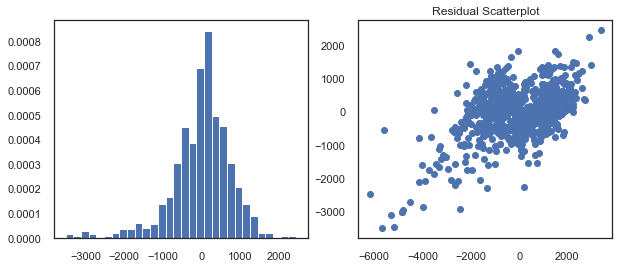

In [73]:
checkresiduals(df, 'resids', final_model[0])